<div style="text-align: right;">
    <h1 style="font-size: 14px; font-weight: normal; color: grey;">Lina Gladutytė</h1>
    <h2 style="font-size: 14px; font-weight: normal; color: grey;">Vilnius University</h2>
    

In [ ]:
%matplotlib inline

<center>

# FOOOF: Fitting Oscillations and One Over F (1/f)

    Hands-on experience with FOOOF algorithm for 
    neural power spectra analysis

</center>

## Introduction


**Our practical goals**: 

- **For me**: Introduction to FOOOF algorithm - parameters it can extract, applications, potential pitfalls. 
- **For you**: Gain a deeper understanding of periodic and aperiodic neural activity and learn how to implement the FOOOF in your own practice.

### **If you want to follow along with your own laptops:**

1. Open the terminal (or Command Prompt).
2. Activate the practical environment:
 
`conda activate <env_name>`
   
3. Open jupyter notebook:

`jupyter notebook`

4. Navigate to the folder where the FOOOF_practical.ipynb file is located and open the file


### Background

#### FOOOF: Fitting Oscillations and One Over F (1/f) 

Neural signal consists of two components:
1. The `aperiodic` component: has a broadband nature (i.e. no characteristic frequencies) and follows a 1/f-like pattern.
2. The `periodic` component: frequency-specific, appears as peaks above the aperiodic component, reflecting oscillatory activity.


FOOOF allows us to extract parameters from these components separately, providing insights into periodic and aperiodic activity without contamination.

![aperiodic_periodic](periodic_aperiodic.png)

*(Donoghue et al., 2020)*

**Why It Matters:**
- Correcting for the aperiodic component is crucial to avoid misleading interpretations of changes in periodic activity.
- Aperiodic component is thought to associated with the balance between excitability and inhibition.

**Useful resources for additional information:**

- [FOOOF documentation](https://fooof-tools.github.io/fooof/): Official documentation for FOOOF, providing in-depth information, usage guidelines, tutorials.
- [https://doi.org/10.1038/s41593-020-00744-x](https://doi.org/10.1038/s41593-020-00744-x): A paper discussing the applications and significance of FOOOF in analyzing neural power spectra.
- [Non-Parametric Approaches to EEG Signal Analysis](https://www.youtube.com/watch?v=OmTY6F0Zl2E&t=1516s): video presentation demonstrating FOOOF's practical usage and highlighting aperiodic activity's importance in EEG signal analysis.

## Preparation for the analysis

**Import necessary packages:**

In [2]:
import os
import scipy.io as spio
import numpy as np
import pandas as pd
from fooof import FOOOF, FOOOFGroup
from fooof.plts.annotate import plot_annotated_model
from fooof.plts.annotate import plot_annotated_peak_search
from fooof.plts.spectra import plot_spectrum

###  **Load data**

**Direct downoad**

(If the following command doesn't work, please follow the alternative instructions below)

In [3]:
# download data
!curl -LJO "https://github.com/linagladutyte/practical_FOOOF/raw/main/PSD_data.npz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6814  100  6814    0     0   6951      0 --:--:-- --:--:-- --:--:--  6951


In [29]:
# Load the data from the downloaded .npz file
data = np.load('PSD_data.npz')
# check the data
data

NpzFile 'PSD_data.npz' with keys: freqs1, powers1, freqs2, powers2_1, powers2_2...

**In case direct download is not working:**

1. Click on the following link to access the data file: [PSD_data.npz](https://github.com/linagladutyte/practical_FOOOF/raw/main/PSD_data.npz).

2. When the page opens, right-click on the "Download" button.

3. Select "Save Link As" or "Download Linked File" (the exact wording may vary depending on the web browser you are using).

4. Choose a location on your computer where you want to save the file and click "Save." To simplify the process, you can save the file in the folder that was returned after using the following command in a code cell (below): `os.getcwd()`.

In [ ]:
# get current working directory
os.getcwd()

##  **Plot power spectra**  

Let's familiarize with the data!

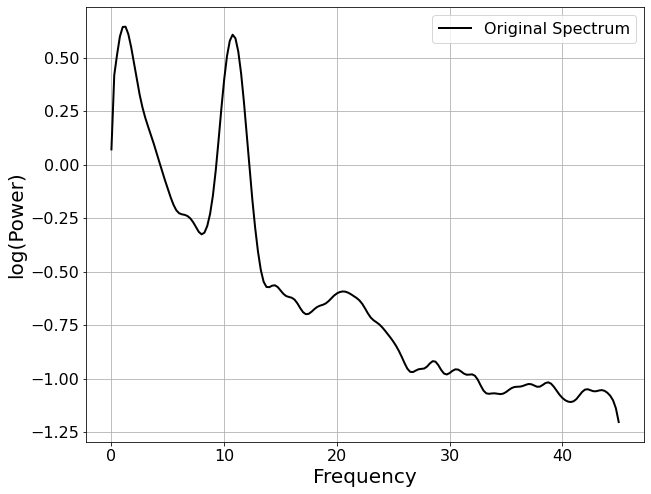

In [30]:
# Plot power spectra
plot_spectrum(data['freqs1'], data['powers1'], log_powers=True, color='black', label='Original Spectrum')

*In this PSD graph, certain frequency regions show pronounced power peaks atop the overall power decrease across frequencies.*


Now, let's fit* the model:

*<span style="font-size:80%;">Fitting the model - determining the most appropriate mathematical representation for the data, considering both periodic (rhythmic) and aperiodic (non-rhythmic) components. </span>


In [9]:
# Set the frequency range upon which to fit FOOOF
freq_range = [3, 40]

In [10]:
# Initialize power spectrum model objects and fit the power spectra
fm = FOOOF()
fm.fit(data['freqs1'], data['powers1'], freq_range)

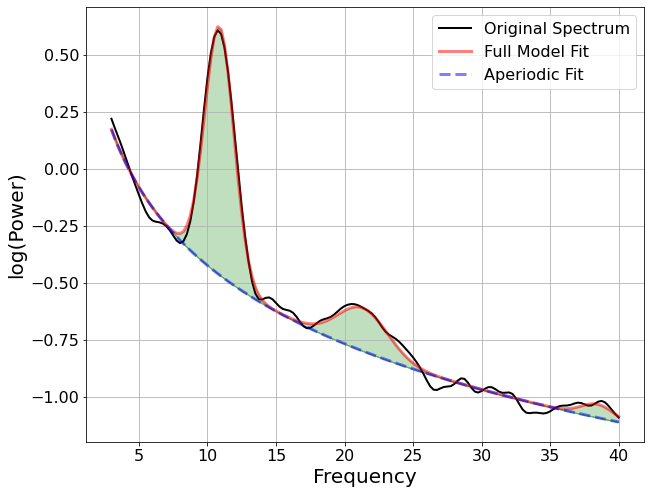

In [11]:
# Plot an example power spectrum, with a model fit
fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})


Full model of power spectrum consists of 2 components:

- `aperiodic (dashed blue line)`: 'non-frequency specific' activity

- `periodic (green-shaded area)`: rhythmic activity with a characteristic frequency

The goal of the model: to measure components and create the full model fit, in a way that accurately and quantitatively describes the data.

*Visual inspection of model fit: good!*



##  Extracting periodic and aperiodic parameters

Let's dive a bit deeper and explore these components separately

### Periodic component

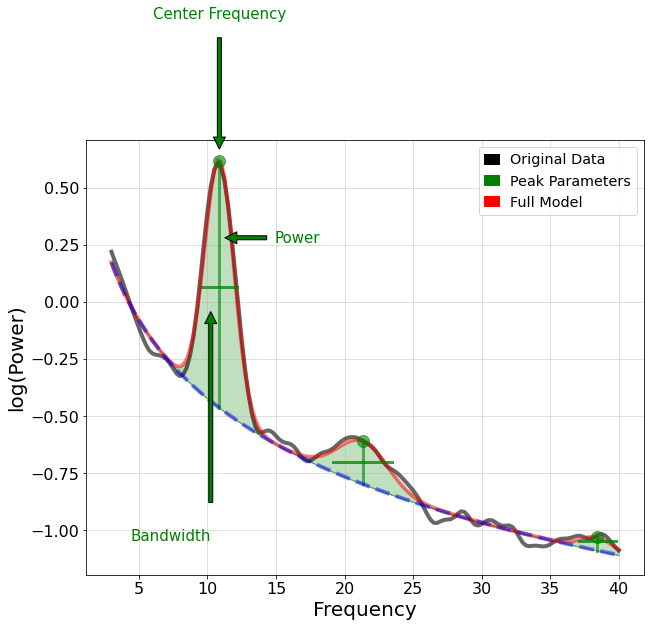

In [12]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm, annotate_aperiodic=False)

The periodic parameters:

- the `center frequency` of the peak, in units of frequency
- the `power` of the peak, over the aperiodic component, in units of power
- the `bandwidth`, or the width of the peak, in units of frequency

Wherever we detect a peak, these are the parameters that we will fit to the peak,
to describe this component of the data.


### Aperiodic component

Aperiodic activity - non-rhytmic activity with no characteristic frequency.

In power spectrum, this activity typically follows 1/f pattern, i.e., the power decreases as a function of frequency following an inverse proportional ($\frac{1}{F^\chi}$) relationship. Thus, lower frequencies have higher power, while higher frequencies have lower power.

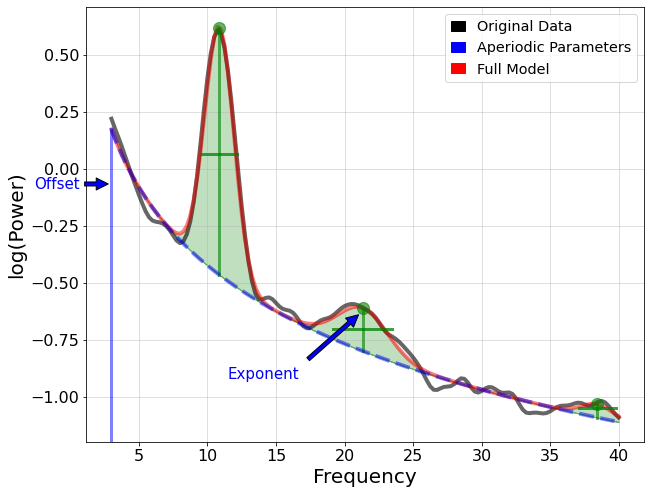

In [13]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm, annotate_peaks=False)

The aperiodic parameters:

- the `offset`, or overall up/down translation of the whole spectrum
- the `exponent`, which describes the 'curve', or overall 'line' of the aperiodic component. It is equivalent to the negative slope of the power spectrum when measured in log–log space

Slope was shown to reflect balance between excitability and inhibition (E/I) - the flatter the slope, the more excitability (Donoghue et al., 2020). 

**To sum up**, we fit the model to a single power spectrum (in our case, data from one participant and one channel) to extract periodic and aperiodic components separately, in order to extract periodic and aperiodic parameters that are not "contaminated" by each other.


## Things to keep in mind when using FOOOF

## The importance of a good model fit

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.7165, 1.1399                                          
                                                                                                  
                                       3 peaks were found:                                        
          

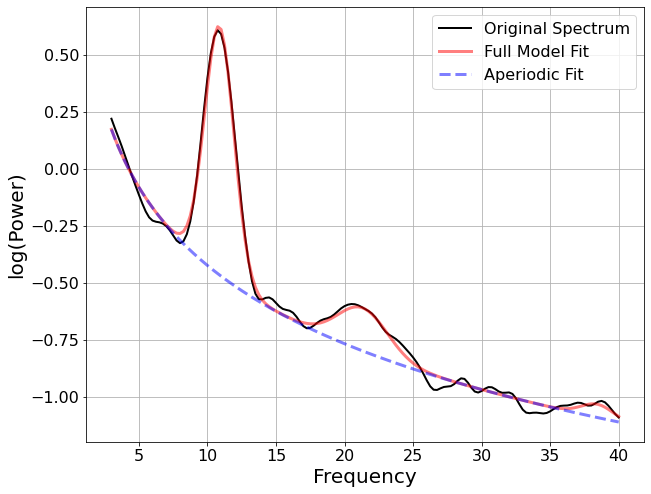

In [31]:
# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report()

R^2 decribes how well model fits the data. It is a number between 0 and 1, where:
- a value of 1 means that the model is perfectly predicting data points;
- a value of 0 means that the model is terrible at making predictions

Thus, the higher the R^2 value, the better the model "explains" data.

The data we have been working with had a good model fit:


In [33]:
print(' R^2 of model fit is ', fm.r_squared_, '\n')

 R^2 of model fit is  0.996398450737191 



In reality, this is not always the case. Let's take a look at data from another participant:


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0571, 0.3772                                          
                                                                                                  
                                       5 peaks were found:                                        
          

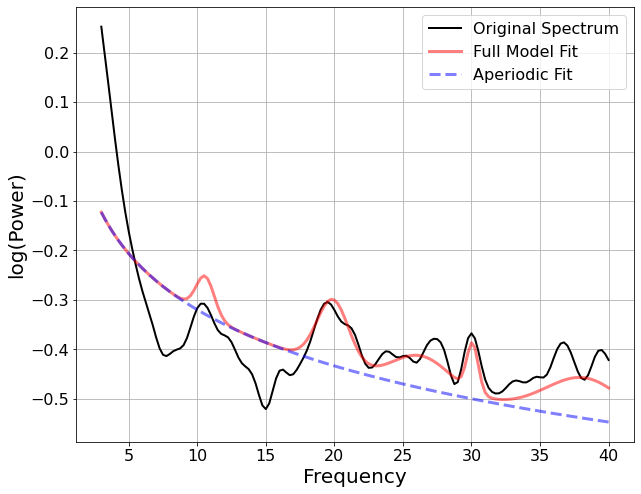

In [34]:
# Initialize power spectrum model objects and fit the power spectra
fm2 = FOOOF()
fm2.fit(data['freqs2'], data['powers2_1'], freq_range)

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm2.report()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.1610, 0.1280                                          
                                                                                                  
                                       5 peaks were found:                                        
          

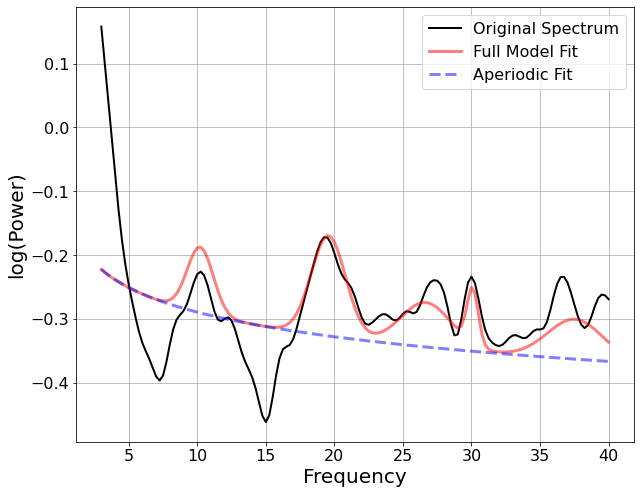

In [35]:
# Initialize power spectrum model objects and fit the power spectra
fm3 = FOOOF()
fm3.fit(data['freqs2'], data['powers2_2'], freq_range)

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm3.report()

**Tip / conclusion: Don't forget to check R^2 value!!**

### Peak search

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.6121, 1.0421                                          
                                                                                                  
                                       5 peaks were found:                                        
          

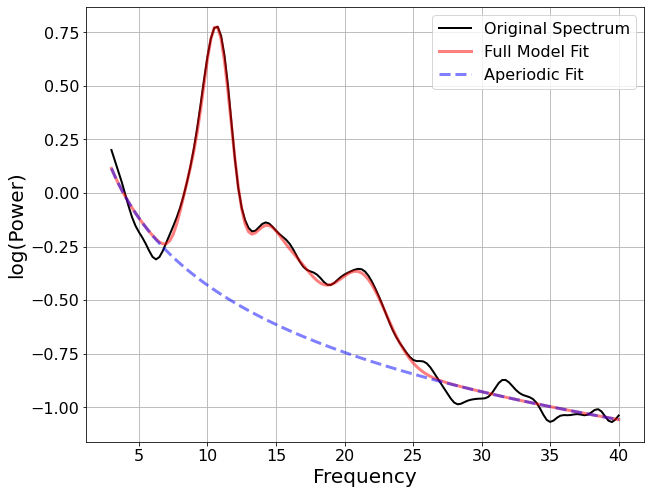

In [36]:
# Initialize power spectrum model objects and fit the power spectra
fm4 = FOOOF()
fm4.fit(data['freqs3'], data['powers3'], freq_range)

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm4.report()

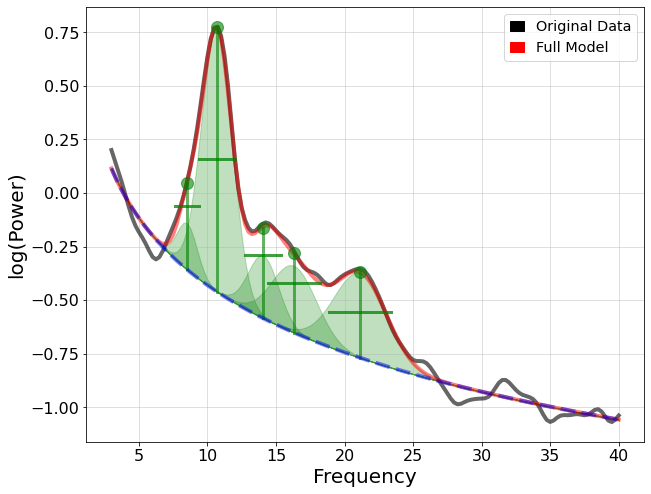

In [26]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm4, annotate_aperiodic=False, annotate_peaks=False)

Oops, a non-existent peak seems to be detected...

Let's try to look more closely at how peaks were detected:

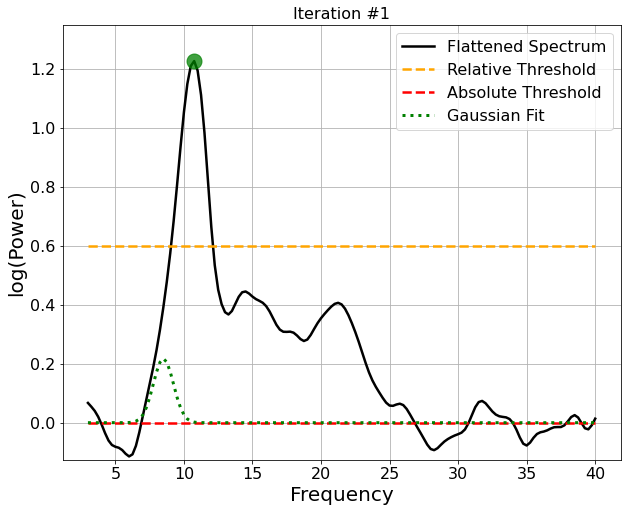

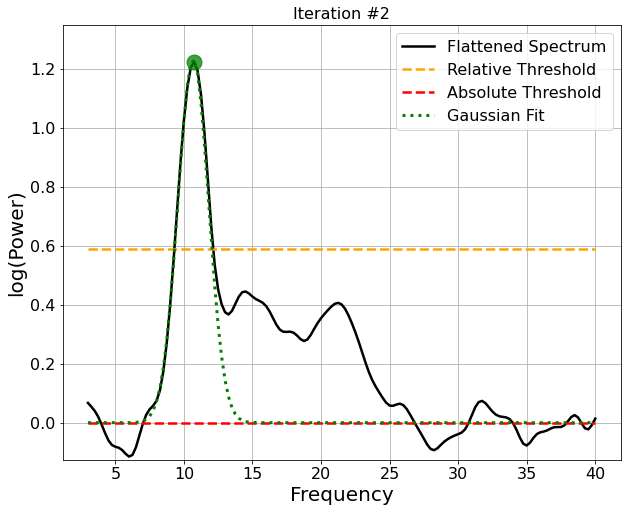

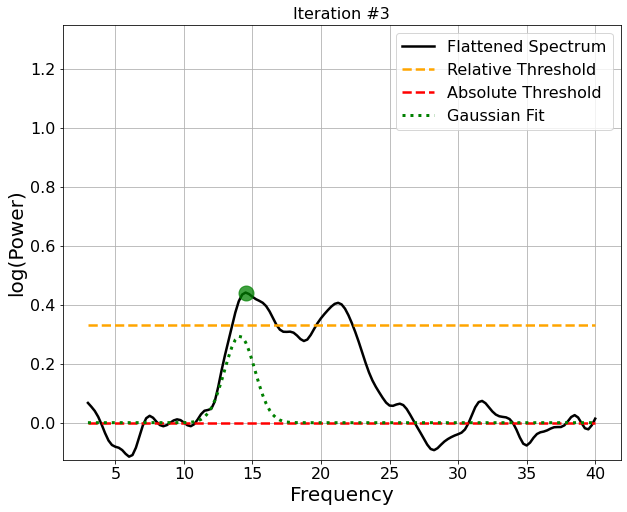

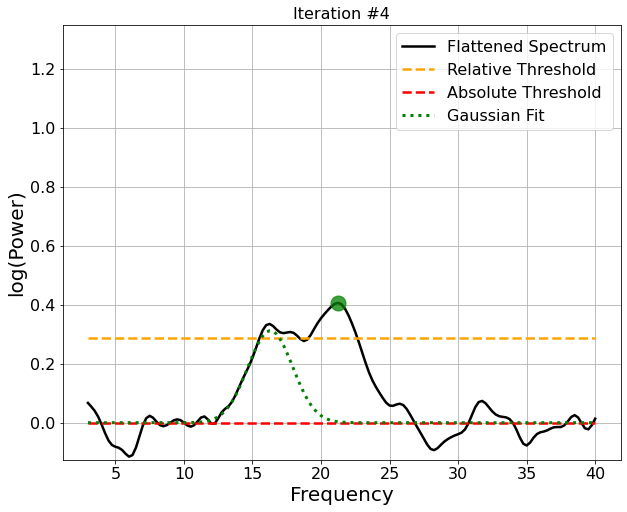

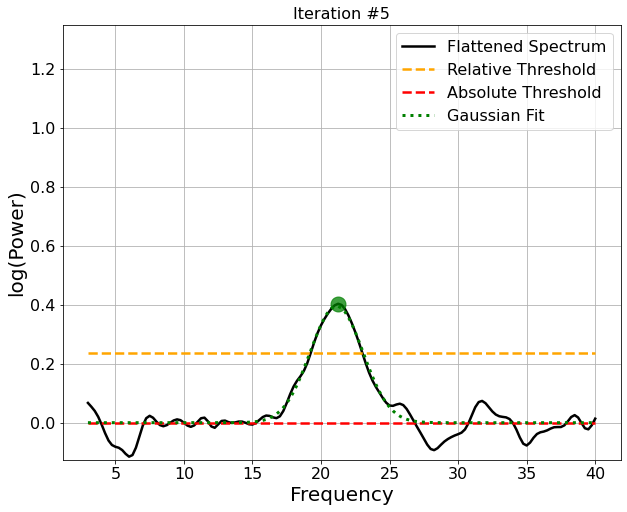

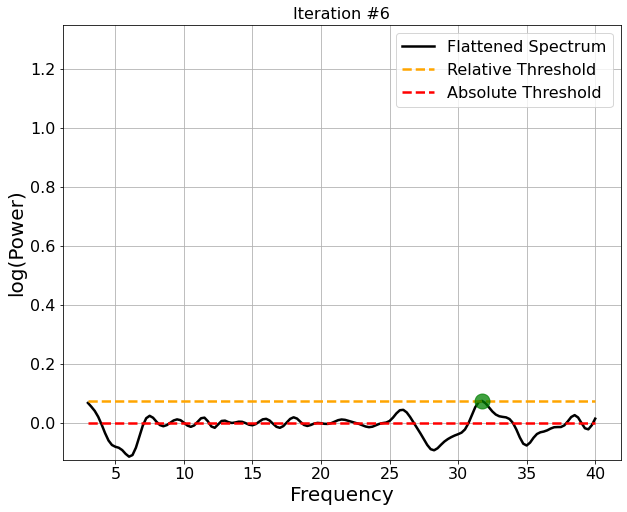

In [37]:
plot_annotated_peak_search(fm4)

**Tip / conclusion: check for (non-existent) double peaks**











### References: 

Donoghue, T., Haller, M., Peterson, E.J. et al. Parameterizing neural power spectra into periodic and aperiodic components. Nat Neurosci 23, 1655–1665 (2020). https://doi.org/10.1038/s41593-020-00744-x

[FOOOF documentation](https://fooof-tools.github.io/fooof/)
    